# 사진에 스티커 합성하기

사진에 고양이 수염을 콜라주하는 어플을 만들어보겠습니다!  
(사실 함수 구현까지만 하겠습니다.)

### 필요한 패키지: opencv, cmake, dlib등등..

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

### 이미지 불러오기

(452, 720, 3)


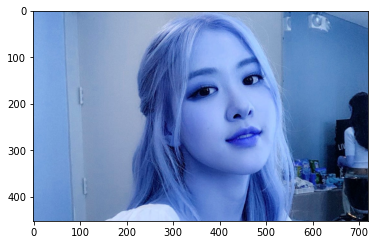

In [2]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/Rose_1.jpg'
img_bgr = cv2.imread(my_image_path) #(1,0,-1)해보기   #- OpenCV로 이미지를 읽어서
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
print(img_bgr.shape)
plt.imshow(img_bgr)
plt.show()

### 색상 보정하기
OPENCV에서는 이미지 채널을 BGR순으로 사용하기 때문에, RGB순으로 바꾸어서 읽어오도록 하자

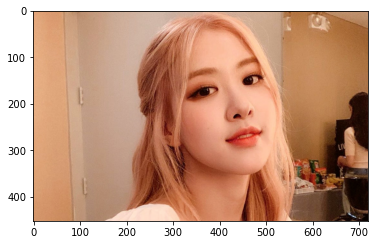

In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 이미지에서 얼굴 검출하기

In [4]:
import dlib
detector_hog = dlib.get_frontal_face_detector()

detector를 이용하여 얼굴의 bounding box추출하기

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

dilb는 RGB로 입력을 받기때문에 opencv의 bgr을 rgb로 변환하였다.

rectangles[[(315, 93) (538, 316)]]


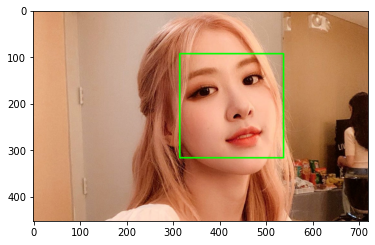

In [6]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face landmark 검출하기

### landmark모델 불러오기

In [7]:
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

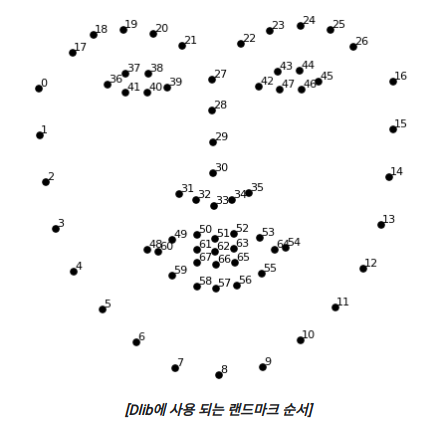

In [8]:
import PIL.Image as pilimg
landmark_image_path = os.getenv('HOME')+'/Downloads/landmarks.png'
landmark_image = pilimg.open(landmark_image_path)
landmark_image

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print('number of point:', len(list_landmarks[0]))

number of point: 68


### landmark 사진에 표시해보기

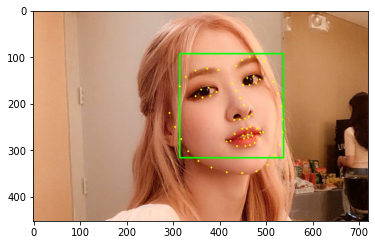

In [10]:
for landmark in list_landmarks:
    for idx, point in enumerate(landmark):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용하기

준비한 스티커는 고양이 수염입니다! 한번 확인해 보도록 하죠

(512, 512, 3)


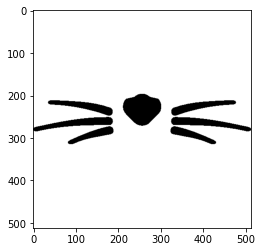

In [11]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

### 스티커붙일 위치찾기

landmark 30번 과 33번의 중점을 스티커의 중심으로 잡도록 하겠습니다.

In [12]:
print(landmark[30]) # nose center index : 30
print(landmark[33]) # philtrum index : 33
center_x = (landmark[30][0] + landmark[33][0])//2
center_y = (landmark[30][1] + landmark[33][1])//2

#center_x = landmark[30][0]
#center_y = landmark[30][1] 
print ('Center point : (%d,%d)'%(center_x,center_y)) 

(453, 203)
(455, 232)
Center point : (454,217)


### 스티커 resize하기
수염 스티커의 width와 landmark의 width를 맞추어주도록 하겠습니다.

In [13]:
sticker_width  = img_sticker.shape[1] #len(img_sticker[1,:])
sticker_height = img_sticker.shape[0] #len(img_sticker[:,1])
resized_sticker_width  = dlib_rect.width()
resized_sticker_height = dlib_rect.width()*sticker_height//sticker_width
img_sticker = cv2.resize(img_sticker, (resized_sticker_width,resized_sticker_height))
print(img_sticker.shape)

(224, 224, 3)


스티커 참조위치 만들어주기

In [14]:
refined_x = center_x - resized_sticker_width//2   # left
refined_y = center_y - resized_sticker_height//2  # top
print ('Center point :      (%d,%d)'%(center_x,center_y)) 
print ('Sticker Top-Left  : (%d,%d)'%(refined_x, refined_y))
print ('Sticker Size(w,h) : (%d,%d)'%(resized_sticker_width,resized_sticker_height))

Center point :      (454,217)
Sticker Top-Left  : (342,105)
Sticker Size(w,h) : (224,224)


혹시 스티커의 사이즈가 사진의 전체 크기를 넘어가는지 체크 해봅시다.

In [15]:
sticker_L = refined_x
sticker_R = refined_x + resized_sticker_width -1
sticker_T = refined_y
sticker_B = refined_y + resized_sticker_height -1

img_L = 0
img_R = len(img_bgr[1,:])
img_T = 0
img_B = len(img_bgr[:,1])

if sticker_L >= img_L:
    print('Left side is OK!')
else :
    print('You should fix the Left side!')
    
if sticker_R <= img_R:
    print('Right side is OK!')
else :
    print('You should fix the Right side!')
    
if sticker_T >= img_T:
    print('Top side is OK!')
else :
    print('You should fix the Top side!')
    
if sticker_B <= img_B:
    print('Bottom side is OK!')
else :
    print('You should fix the bottom side!')

Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


스티커가 사진안에 잘들어와 있으니 crop은 안해도 될 것 같습니다.

In [16]:
img_show_temp1 = img_show.copy()
sticker_area1 = img_show_temp1[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width]
img_show_temp1[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width] = \
    np.where(img_sticker==255 ,sticker_area1,img_sticker).astype(np.uint8)

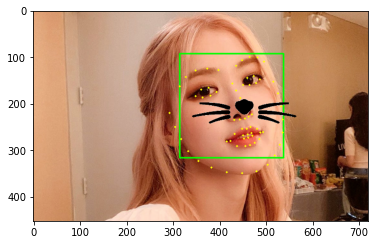

In [17]:
plt.imshow(cv2.cvtColor(img_show_temp1, cv2.COLOR_BGR2RGB))
plt.show()

스티커가 원하는 위치에 위치한것 같습니다. 하지만 얼굴각도와는 살짝 어긋난 느낌이 듭니다.  
사실 스티커가 어긋나 있어서 조금 많이 불편한데요..그걸 해결해보도록 하겠습니다!

## 스티커 회전시키기

회전시키기에 앞서 스티커에 대한 정보를 다시 정리해보도록 하겠습니다.

(224, 224, 3)


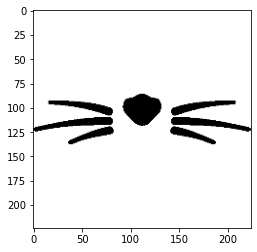

Center point :      (454,217)


In [18]:
sticker_width           #초기 width
sticker_height          #초기 height
resized_sticker_width   #변환후 width
resized_sticker_height  #변환후 height
img_sticker             #변환된 sticker
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()
print ('Center point :      (%d,%d)'%(center_x,center_y)) 

회전을 시키기 위해선 회전의 기준점인 중심점과 회전시킬 각도가 필요합니다.  
중심점은 center point를 사용할 것입니다.  
각도는 다음과 같은 방법을 통해 구하겠습니다.  

1) landmark 27번과 33번을 이어 새로운 직선을 만듭니다.   
2) 이 만들어진 직선이 기존의 y축으로 부터 얼마만큼의 각도로 회전되었는지 구합니다.  

In [19]:
import math
theta = math.atan((landmark[33][0]-landmark[27][0])/(landmark[33][1]-landmark[27][1]))/math.pi *180
theta = round(theta,2)
print('theta : ','%.2f'%(theta),'degree(CCW)')

theta :  19.80 degree(CCW)


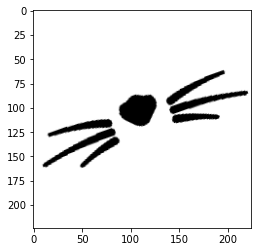

In [20]:
height, width, channel = img_sticker.shape
matrix = cv2.getRotationMatrix2D((width/2, height/2), theta, 1)
Rotated_img_sticker = cv2.warpAffine(img_sticker, matrix, (width, height),borderValue=(255,255,255))

plt.imshow(Rotated_img_sticker)
plt.show()

In [21]:
img_show_temp2 = img_show.copy()
sticker_area2 = img_show_temp2[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width]
img_show_temp2[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width] = \
    np.where(Rotated_img_sticker==255 ,sticker_area2,Rotated_img_sticker).astype(np.uint8)

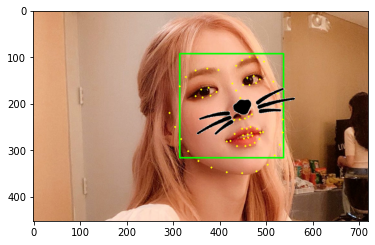

In [22]:
plt.imshow(cv2.cvtColor(img_show_temp2, cv2.COLOR_BGR2RGB))
plt.show()

스티커의 회전도 잘된것 같습니다.  
사실 아직 고려하지 않은 부분이 한가지 있습니다. 바로 스티커의 좌우비율인데요!  
지금은 괜찮아 보이지만 얼굴이 항상 사진의 정면만을 바라보는 것이 아니기 때문에 조절을 해주어야 합니다.    
이 작업은 회전 변환 이전으로 돌아가서 실행해야 합니다.  
다시 초심으로 돌아가서 작업해보도록 하겠습니다. 

## 얼굴의 좌우 각도에 따른 스티커 Width 조절하기

일단 스티커의 y = width/2지점으로 반을 나눈후 landmark의 비율에 맞게 조절하도록 하겠습니다.  



(224, 224, 3)


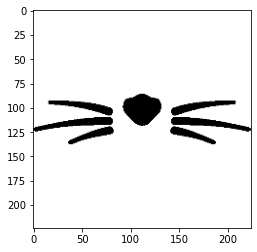

Center point :      (454,217)


In [23]:
sticker_width           #초기 width
sticker_height          #초기 height
resized_sticker_width   #변환후 width
resized_sticker_height  #변환후 height
img_sticker             #변환된 sticker
print(img_sticker.shape)
plt.imshow(img_sticker)
plt.show()
print ('Center point :      (%d,%d)'%(center_x,center_y)) 

(224, 112, 3)


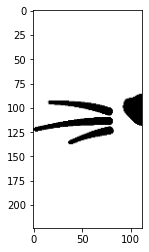

In [24]:
img_sticker_L = img_sticker[:,:resized_sticker_width//2,:].copy()
print(img_sticker_L.shape)
plt.imshow(img_sticker_L)
plt.show()

(224, 112, 3)


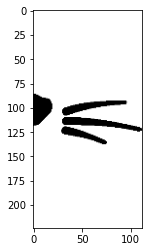

In [25]:
img_sticker_R = img_sticker[:,resized_sticker_width//2:,:].copy()
print(img_sticker_R.shape)
plt.imshow(img_sticker_R)
plt.show()

좌우간격의 비교를 landmark의 2번,30번,14번의 x좌표를 통해 계산하도록 하겠습니다.

In [26]:
# -90 < theta < 90도라고 가정한다.
Left_side_width = landmark[30][0]-landmark[2][0]
Right_side_width = landmark[14][0]-landmark[30][0]

Smaller_part_width = (resized_sticker_width//2)* \
                    min(Left_side_width, Right_side_width)//max(Left_side_width, Right_side_width)
Smaller_part_width = (Smaller_part_width + (resized_sticker_width//2))//2
# smaller part의 수염길이가 조금 짧아 지는 경향이 보여서 조절을 해주었습니다.

if max(Left_side_width, Right_side_width) == Left_side_width:
    img_sticker_R = cv2.resize(img_sticker_R, (Smaller_part_width,resized_sticker_height))
else:
    img_sticker_L = cv2.resize(img_sticker_L, (Smaller_part_width,resized_sticker_height))


(224, 89, 3)


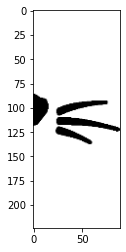

In [27]:
print(img_sticker_R.shape)
plt.imshow(img_sticker_R)
plt.show()

(224, 112, 3)


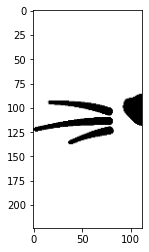

In [28]:
print(img_sticker_L.shape)
plt.imshow(img_sticker_L)
plt.show()

좌우의 사이즈가 정해졌으니 스티커의 원본을 도화지로 만든 다음에 붙여주도록 하겠습니다.

In [29]:
img_sticker_temp = img_sticker.copy()

In [30]:
img_sticker_temp[:]=255

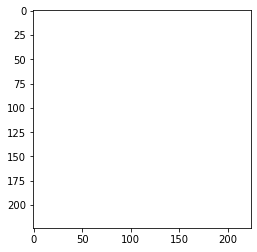

In [31]:
plt.imshow(img_sticker_temp)
plt.show()

In [32]:
if max(Left_side_width, Right_side_width) == Left_side_width:
    
    sticker_area3 = img_sticker_temp[:,:(resized_sticker_width//2),:]
    img_sticker_temp[:,:(resized_sticker_width//2),:] = \
        np.where(img_sticker_L==255,sticker_area3,img_sticker_L)
    
    sticker_area4 = img_sticker_temp[:,(resized_sticker_width//2):(resized_sticker_width//2)+Smaller_part_width,:]
    img_sticker_temp[:,(resized_sticker_width//2):(resized_sticker_width//2)+Smaller_part_width,:] = \
        np.where(img_sticker_R==255,sticker_area4,img_sticker_R)   
    
else: # Right side is wider than Left side
    sticker_area3 = img_sticker_temp[:,(resized_sticker_width//2)-Smaller_part_width:(resized_sticker_width//2),:]
    img_sticker_temp[:,(resized_sticker_width//2)-Smaller_part_width:(resized_sticker_width//2),:] = \
        np.where(img_sticker_L==255,sticker_area3,img_sticker_L)
    
    sticker_area4 = img_sticker_temp[:,(resized_sticker_width//2):,:]
    img_sticker_temp[:,(resized_sticker_width//2):,:] = \
        np.where(img_sticker_R==255,sticker_area4,img_sticker_R)

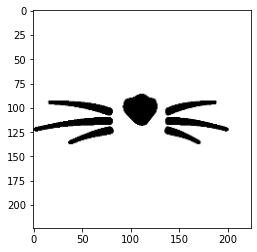

In [33]:
plt.imshow(img_sticker_temp)
plt.show()

회전 작업을 다시 해주도록 하겠습니다.

In [34]:
import math
theta = math.atan((landmark[33][0]-landmark[27][0])/(landmark[33][1]-landmark[27][1]))/math.pi *180
theta = round(theta,2)
print('theta : ','%.2f'%(theta),'degree(CCW)')

theta :  19.80 degree(CCW)


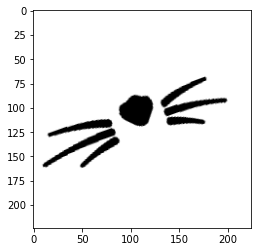

In [35]:
height, width, channel = img_sticker_temp.shape
matrix = cv2.getRotationMatrix2D((width/2, height/2), theta, 1)
img_sticker_final = cv2.warpAffine(img_sticker_temp, matrix, (width, height),borderValue=(255,255,255))

plt.imshow(img_sticker_final)
plt.show()

In [36]:
img_show_temp3 = img_show.copy()
sticker_area3 = img_show_temp3[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width]
img_show_temp3[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width] = \
    np.where(img_sticker_final==255 ,sticker_area3,img_sticker_final).astype(np.uint8)

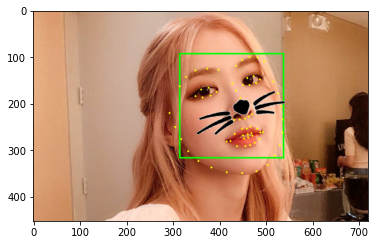

In [37]:
plt.imshow(cv2.cvtColor(img_show_temp3, cv2.COLOR_BGR2RGB))
plt.show()

최종적으로 처음 백업해두었던 img_bgr에 스티커만 붙여도록하겠습니다!

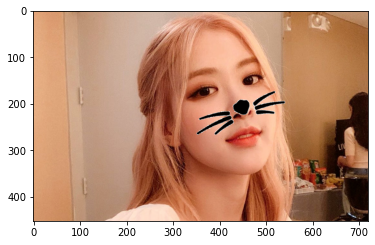

In [38]:
sticker_area4 = img_bgr[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width]
img_bgr[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width] = \
    np.where(img_sticker_final==255 ,sticker_area4,img_sticker_final).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

스티커가 잘 적용된것 같습니다! 이제 함수형으로 만들어 여러사진에 적용시켜보도록 하겠습니다.

### 함수형으로 정의하기

In [39]:
def Add_cat_whisker(image, sticker):

    
    ####Import_image####

    import os
    folder = os.getenv('HOME')+'/aiffel/camera_sticker/images/'

    image_path = folder + image
    img_bgr = cv2.imread(image_path)
    img_show = img_bgr.copy() #- 출력용 이미지 별도 보관

    sticker_path = folder + sticker
    img_sticker = cv2.imread(sticker_path)

    ####Find_bounding_box####

    import dlib
    detector_hog = dlib.get_frontal_face_detector()

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1)

    ####Face_landmark_dection####

    import os
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    
    for landmark in list_landmarks:
        for idx, point in enumerate(landmark):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

    ####Sticker_attachment_point####

    center_x = (landmark[30][0] + landmark[33][0])//2
    center_y = (landmark[30][1] + landmark[33][1])//2

    ####Sticker_first_resize####

    sticker_width  = img_sticker.shape[1]
    sticker_height = img_sticker.shape[0]
    resized_sticker_width  = dlib_rect.width()
    resized_sticker_height = dlib_rect.width()*sticker_height//sticker_width
    img_sticker = cv2.resize(img_sticker, (resized_sticker_width,resized_sticker_height))

    ####Sticker_attachment_point####

    center_x = (landmark[30][0] + landmark[33][0])//2
    center_y = (landmark[30][1] + landmark[33][1])//2   
    refined_x = center_x - resized_sticker_width//2   # left
    refined_y = center_y - resized_sticker_height//2  # top

    ####Sticker_size_check####
    sticker_L = refined_x
    sticker_R = refined_x + resized_sticker_width -1
    sticker_T = refined_y
    sticker_B = refined_y + resized_sticker_height -1

    img_L = 0
    img_R = len(img_bgr[1,:])
    img_T = 0
    img_B = len(img_bgr[:,1])

    print('Sticker size check!')
    if sticker_L >= img_L:
        print('Left side is OK!')
    else :
        print('You should fix the Left side!')

    if sticker_R <= img_R:
        print('Right side is OK!')
    else :
        print('You should fix the Right side!')

    if sticker_T >= img_T:
        print('Top side is OK!')
    else :
        print('You should fix the Top side!')

    if sticker_B <= img_B:
        print('Bottom side is OK!')
    else :
        print('You should fix the bottom side!')

    ####Sticker_width_control####

    img_sticker_L = img_sticker[:,:resized_sticker_width//2,:].copy()
    img_sticker_R = img_sticker[:,resized_sticker_width//2:,:].copy()

    Left_side_width = landmark[30][0]-landmark[2][0]
    Right_side_width = landmark[14][0]-landmark[30][0]

    Smaller_part_width = (resized_sticker_width//2)* \
                        min(Left_side_width, Right_side_width)//max(Left_side_width, Right_side_width)
    Smaller_part_width = (Smaller_part_width + (resized_sticker_width//2))//2
    # smaller part의 수염길이가 조금 짧아 지는 경향이 보여서 조절을 해주었습니다.

    if max(Left_side_width, Right_side_width) == Left_side_width:
        img_sticker_R = cv2.resize(img_sticker_R, (Smaller_part_width,resized_sticker_height))
    else:
        img_sticker_L = cv2.resize(img_sticker_L, (Smaller_part_width,resized_sticker_height))

    img_sticker_temp = img_sticker.copy()
    img_sticker_temp[:]=255

    if max(Left_side_width, Right_side_width) == Left_side_width:

        sticker_area3 = img_sticker_temp[:,:(resized_sticker_width//2),:]
        img_sticker_temp[:,:(resized_sticker_width//2),:] = \
            np.where(img_sticker_L==255,sticker_area3,img_sticker_L)

        sticker_area4 = img_sticker_temp[:,(resized_sticker_width//2):(resized_sticker_width//2)+Smaller_part_width,:]
        img_sticker_temp[:,(resized_sticker_width//2):(resized_sticker_width//2)+Smaller_part_width,:] = \
            np.where(img_sticker_R==255,sticker_area4,img_sticker_R)   

    else: # Right side is wider than Left side
        sticker_area3 = img_sticker_temp[:,(resized_sticker_width//2)-Smaller_part_width:(resized_sticker_width//2),:]
        img_sticker_temp[:,(resized_sticker_width//2)-Smaller_part_width:(resized_sticker_width//2),:] = \
            np.where(img_sticker_L==255,sticker_area3,img_sticker_L)

        sticker_area4 = img_sticker_temp[:,(resized_sticker_width//2):,:]
        img_sticker_temp[:,(resized_sticker_width//2):,:] = \
            np.where(img_sticker_R==255,sticker_area4,img_sticker_R)

    ####Sticker_rotation####
    import math
    theta = math.atan((landmark[33][0]-landmark[27][0])/(landmark[33][1]-landmark[27][1]))/math.pi *180
    theta = round(theta,2)

    height, width, channel = img_sticker_temp.shape
    matrix = cv2.getRotationMatrix2D((width/2, height/2), theta, 1)
    img_sticker_final = cv2.warpAffine(img_sticker_temp, matrix, (width, height),borderValue=(255,255,255))

    sticker_area5 = img_bgr[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width]
    img_bgr[refined_y:refined_y+resized_sticker_height, refined_x:refined_x+resized_sticker_width] = \
        np.where(img_sticker_final==255 ,sticker_area5,img_sticker_final).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

Sticker size check!
Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


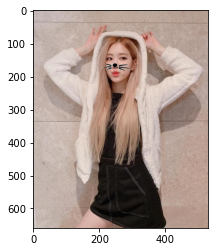

In [40]:
Add_cat_whisker('Rose_2.jpg', 'cat-whiskers.png')

Sticker size check!
Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


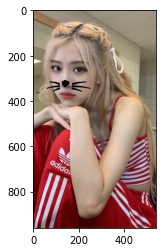

In [41]:
Add_cat_whisker('Rose_3.jpg', 'cat-whiskers.png')

Sticker size check!
Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


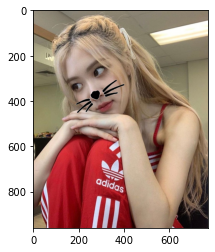

In [42]:
Add_cat_whisker('Rose_4.jpg', 'cat-whiskers.png')

Sticker size check!
Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


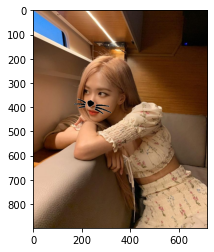

In [43]:
Add_cat_whisker('Rose_5.jpg', 'cat-whiskers.png')

Sticker size check!
Left side is OK!
Right side is OK!
Top side is OK!
Bottom side is OK!


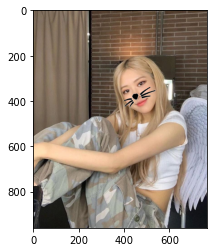

In [44]:
Add_cat_whisker('Rose_6.jpg', 'cat-whiskers.png')

# 결과 및 총평

OPENCV를 사용하여 주어진 사진에서 얼굴을 찾고, 그 얼굴에 맞춰 고양이 수염을 붙여보는 작업을 하였습니다.  

크게 고려했던 것은 4가지 였습니다.  
1) 스티커의 사이즈를 어떻게 조절할 것인가  
2) 스티커를 사진의 어느부분에 합성할 것인가  
3) 스티커를 얼마만큼 회전시킬것인가  
4) 스티커의 좌우비율을 어떻게 조절 할것인가  

위에서 4가지 고려사항을 모두 충족한 함수를 만들어내었고 각 사진에서도 만족스러운 결과를 얻어낼 수 있었습니다.